In [1]:
import math
import numpy as np
import pandas as pd

import scipy.stats
from scipy import stats
from scipy.stats import chisquare
from scipy.stats import chi2
from scipy.optimize import minimize

# plotting
import matplotlib
from matplotlib.pyplot import figure
from matplotlib.colors import LogNorm
from matplotlib import rc
import matplotlib.pylab as plt

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

In [2]:
def dis_potential (threshold, signals):
    """
    Compute the power of the test by counting the 
    number of test statistics that exceed the rejection threshold
    
    """
    count = 0
    power = 0
    
    for i in range(len(signals)):
        if (signals[i] >= threshold):
            count+=1
    power = (count/len(signals))
    
    return power

def compute_mean_vector(samples):
    """
    This is a helper function that compute the mean vectors
    from the input samples, which can be 1000 cross-correlations for instance.
    
    """
    mean_vector = np.zeros(len(samples[0]))
    
    for i in range(len(samples)):
        mean_vector += samples[i]
        
    mean_vector = mean_vector/len(samples)
    
    return mean_vector

def compute_variance_vector(samples):
    """
    This is a helper function that compute the variance of the cross-correlation 
    at each linear bin from the input samples.
    
    """
    
    variances = np.zeros(len(samples[0]))
    
    for i in range(len(variances)):
        holder = []
        for j in range(1000):
            holder.append(samples[j][i])
        variances[i] = np.var(holder, ddof=0) # this compute the sample variance, same with stat.variance
        
    return variances


def log_likelihood_mvn (mean_vector, inv_covmat, data):
    """
    Compute the log-likelihood for the cross-correlation as defined in the paper
    
    """
    T1 = np.dot((data - mean_vector).T, inv_covmat)
    T2 = np.dot(T1, (data - mean_vector))
    l = (-1/2)*T2

    return l

def compute_TS(data, k):
    """
    This function compute the Likelihood Ratio Test statistics as defined in 
    the Equation 7 in the paper. We provide several cross-correlations with 
    different f_astro and normalizations, and each file contains in total of 
    1000 cross-correlations.
    
    The inputs are the cross-correlations (provided) and the
    specific k determines which kNN-CDFs cross-correlations will be used
    in the computation
       
    Parameters
    ----------
    
    data: 'list'
        an nested list of cross-correlations with a specific f_astro; 
        each one of the 1000 cross-correlations with a specific k and f_astro
        is in the form of a length-50 ndarray
    k: 'int'
        The k that determines which kNN-CDFs cross-correlations will be used
        in the computation
    
    
    Returns
    -------
    
    TS: 'ndarray'
        Test statistics computed for all the cross-correlations at a specific k
        and f_astro
    
    
    """
    likelihoods = []
    likelihoods_null = []
    for i in range(len(data[k])):
        inv_covmat = np.linalg.inv(np.cov(np.array(correlated_cc[0][k]).T))
        fun = lambda x: -log_likelihood_mvn(mean_vectors_bg_astro[0][k]*(1-x) + mean_vectors_bg_astro[1][k]*x, 
                                            inv_covmat, data[k][i])

        x = minimize(fun, x0 = 0.01, bounds=[(-1, 1)]).x[0] # f_astro_mle

        # log-likelihoods under mle (f_astro = f_astro_mle)
        ts_1 = log_likelihood_mvn(mean_vectors_bg_astro[0][k]*(1-x) + mean_vectors_bg_astro[1][k]*x,
                       inv_covmat, data[k][i])

        # log-likelihoods under null hypothesis (f_astro = 0)
        ts_0 = log_likelihood_mvn(mean_vectors_bg_astro[0][k]*(1-0) + mean_vectors_bg_astro[1][k]*0,
                       inv_covmat, data[k][i])

        likelihoods.append(ts_1)
        likelihoods_null.append(ts_0)

    TS = 2 * (np.array(likelihoods) - np.array(likelihoods_null))
    
    return TS

In [3]:
# read and process data

In [4]:
# read correlated_cc and kNN distances of cc data from pkl
# note that the uncorrelated_cc is stored at the 0 indec
correlated_cc = [[] for i in range(5)]

correlated_cc[0] = pd.read_pickle("./data/uncorrelated_cc.pkl").values.tolist()
correlated_cc[1] = pd.read_pickle("./data/correlated_cc_1-864.pkl").values.tolist()
correlated_cc[2] = pd.read_pickle("./data/correlated_cc_3-735.pkl").values.tolist()
correlated_cc[3] = pd.read_pickle("./data/correlated_cc_SPARSER-1PS.pkl").values.tolist()
correlated_cc[4] = pd.read_pickle("./data/correlated_cc_DENSER-10PS.pkl").values.tolist()

# read bincfrom pkl as df
df_binc = pd.read_pickle("./data/binc.pkl")
binc = df_binc.values.tolist()

range_k = list(range(1, 31))
plot_k = [1,5,10,20]

In [5]:
# data processing into 30 by 1000
holder1 = [[] for i in range(len(correlated_cc))] # total length = number of f_astro
for i in range(len(correlated_cc)):
    holder3 = [[] for i in range(len(range_k))] # len = 30, holding 1000 samples at each k for a specific f_astrto
    for j in range(len(range_k)): # through each k
        holder2 = [[] for i in range(len(correlated_cc[0][0]))] # len = 1000, synthetic samples for a specific k
        for k in range(len(correlated_cc[0][0])): # through each sample
            # fix a specific f_astro, for each 1/1000, attach the jth 
            holder2[k] = correlated_cc[i][0][k][j] # 
        holder3[j] = holder2
    holder1[i] = holder3

correlated_cc = holder1


# calculate the mean vector and variance vector for each f_astro anf for each k
mean_vectors = [[] for i in range(len(correlated_cc))]
variance_vectors = [[] for i in range(len(correlated_cc))]

for i in range(len(correlated_cc)):
    holder = [[] for i in range(len(range_k))] # for each f_astro, create a len = 30 list
    holder2 = [[] for i in range(len(range_k))] # for each f_astro, create a len = 30 list
    for j in range(len(range_k)):
        holder[j] = compute_mean_vector(correlated_cc[i][j])
        holder2[j] = compute_variance_vector(correlated_cc[i][j])
        
    mean_vectors[i] = holder
    variance_vectors[i] = holder2

In [6]:
data_holder = [[] for i in range(2)]

# read and process the cross-correlations between
# 1. WISE and atmospheric-only events
# 2. WISE and astrophysical-only events
correlated_cc_bgOnly = pd.read_pickle("./data/uncorrelated_cc.pkl").values.tolist()
correlated_cc_pureAstro = pd.read_pickle("./data/correlated_cc_pureAstro.pkl").values.tolist()

data_holder[0] = correlated_cc_bgOnly
data_holder[1] = correlated_cc_pureAstro

# data processing into 30 by 1000
holder1 = [[] for i in range(len(data_holder))] # total length = number of f_astro
for i in range(len(data_holder)):
    holder3 = [[] for i in range(len(range_k))] # len = 30, holding 1000 samples at each k for a specific f_astrto
    for j in range(len(range_k)): # through each k
        holder2 = [[] for i in range(len(data_holder[0][0]))] # len = 1000, synthetic samples for a specific k
        for k in range(len(correlated_cc[0][0])): # through each sample
            # fix a specific f_astro, for each 1/1000, attach the jth 
            holder2[k] = data_holder[i][0][k][j] # 
        holder3[j] = holder2
    holder1[i] = holder3

data_holder = holder1


mean_vectors_bg_astro = [[] for i in range(len(data_holder))]

for i in range(len(data_holder)):
    holder = [[] for i in range(len(range_k))] # for each f_astro, create a len = 30 list
    for j in range(len(range_k)):
        holder[j] = compute_mean_vector(data_holder[i][j])
        
    mean_vectors_bg_astro[i] = holder

In [7]:
# computing the power v.s. k curves

In [8]:
dp_1 = [[] for i in range(30)]
dp_2 = [[] for i in range(30)]
dp_3 = [[] for i in range(30)]

In [9]:
for k in range(30):
    # compute statistical power for cross-correlations with f_astro ~ 0.0374
    # respectively at normalization of a median of 1, 5, and 10 events per source
    dp_1[k] = dis_potential(scipy.stats.chi2.ppf(1-2.85e-7, df=1), compute_TS(correlated_cc[2], k))
    dp_2[k] = dis_potential(scipy.stats.chi2.ppf(1-2.85e-7, df=1), compute_TS(correlated_cc[3], k))
    dp_3[k] = dis_potential(scipy.stats.chi2.ppf(1-2.85e-7, df=1), compute_TS(correlated_cc[4], k))

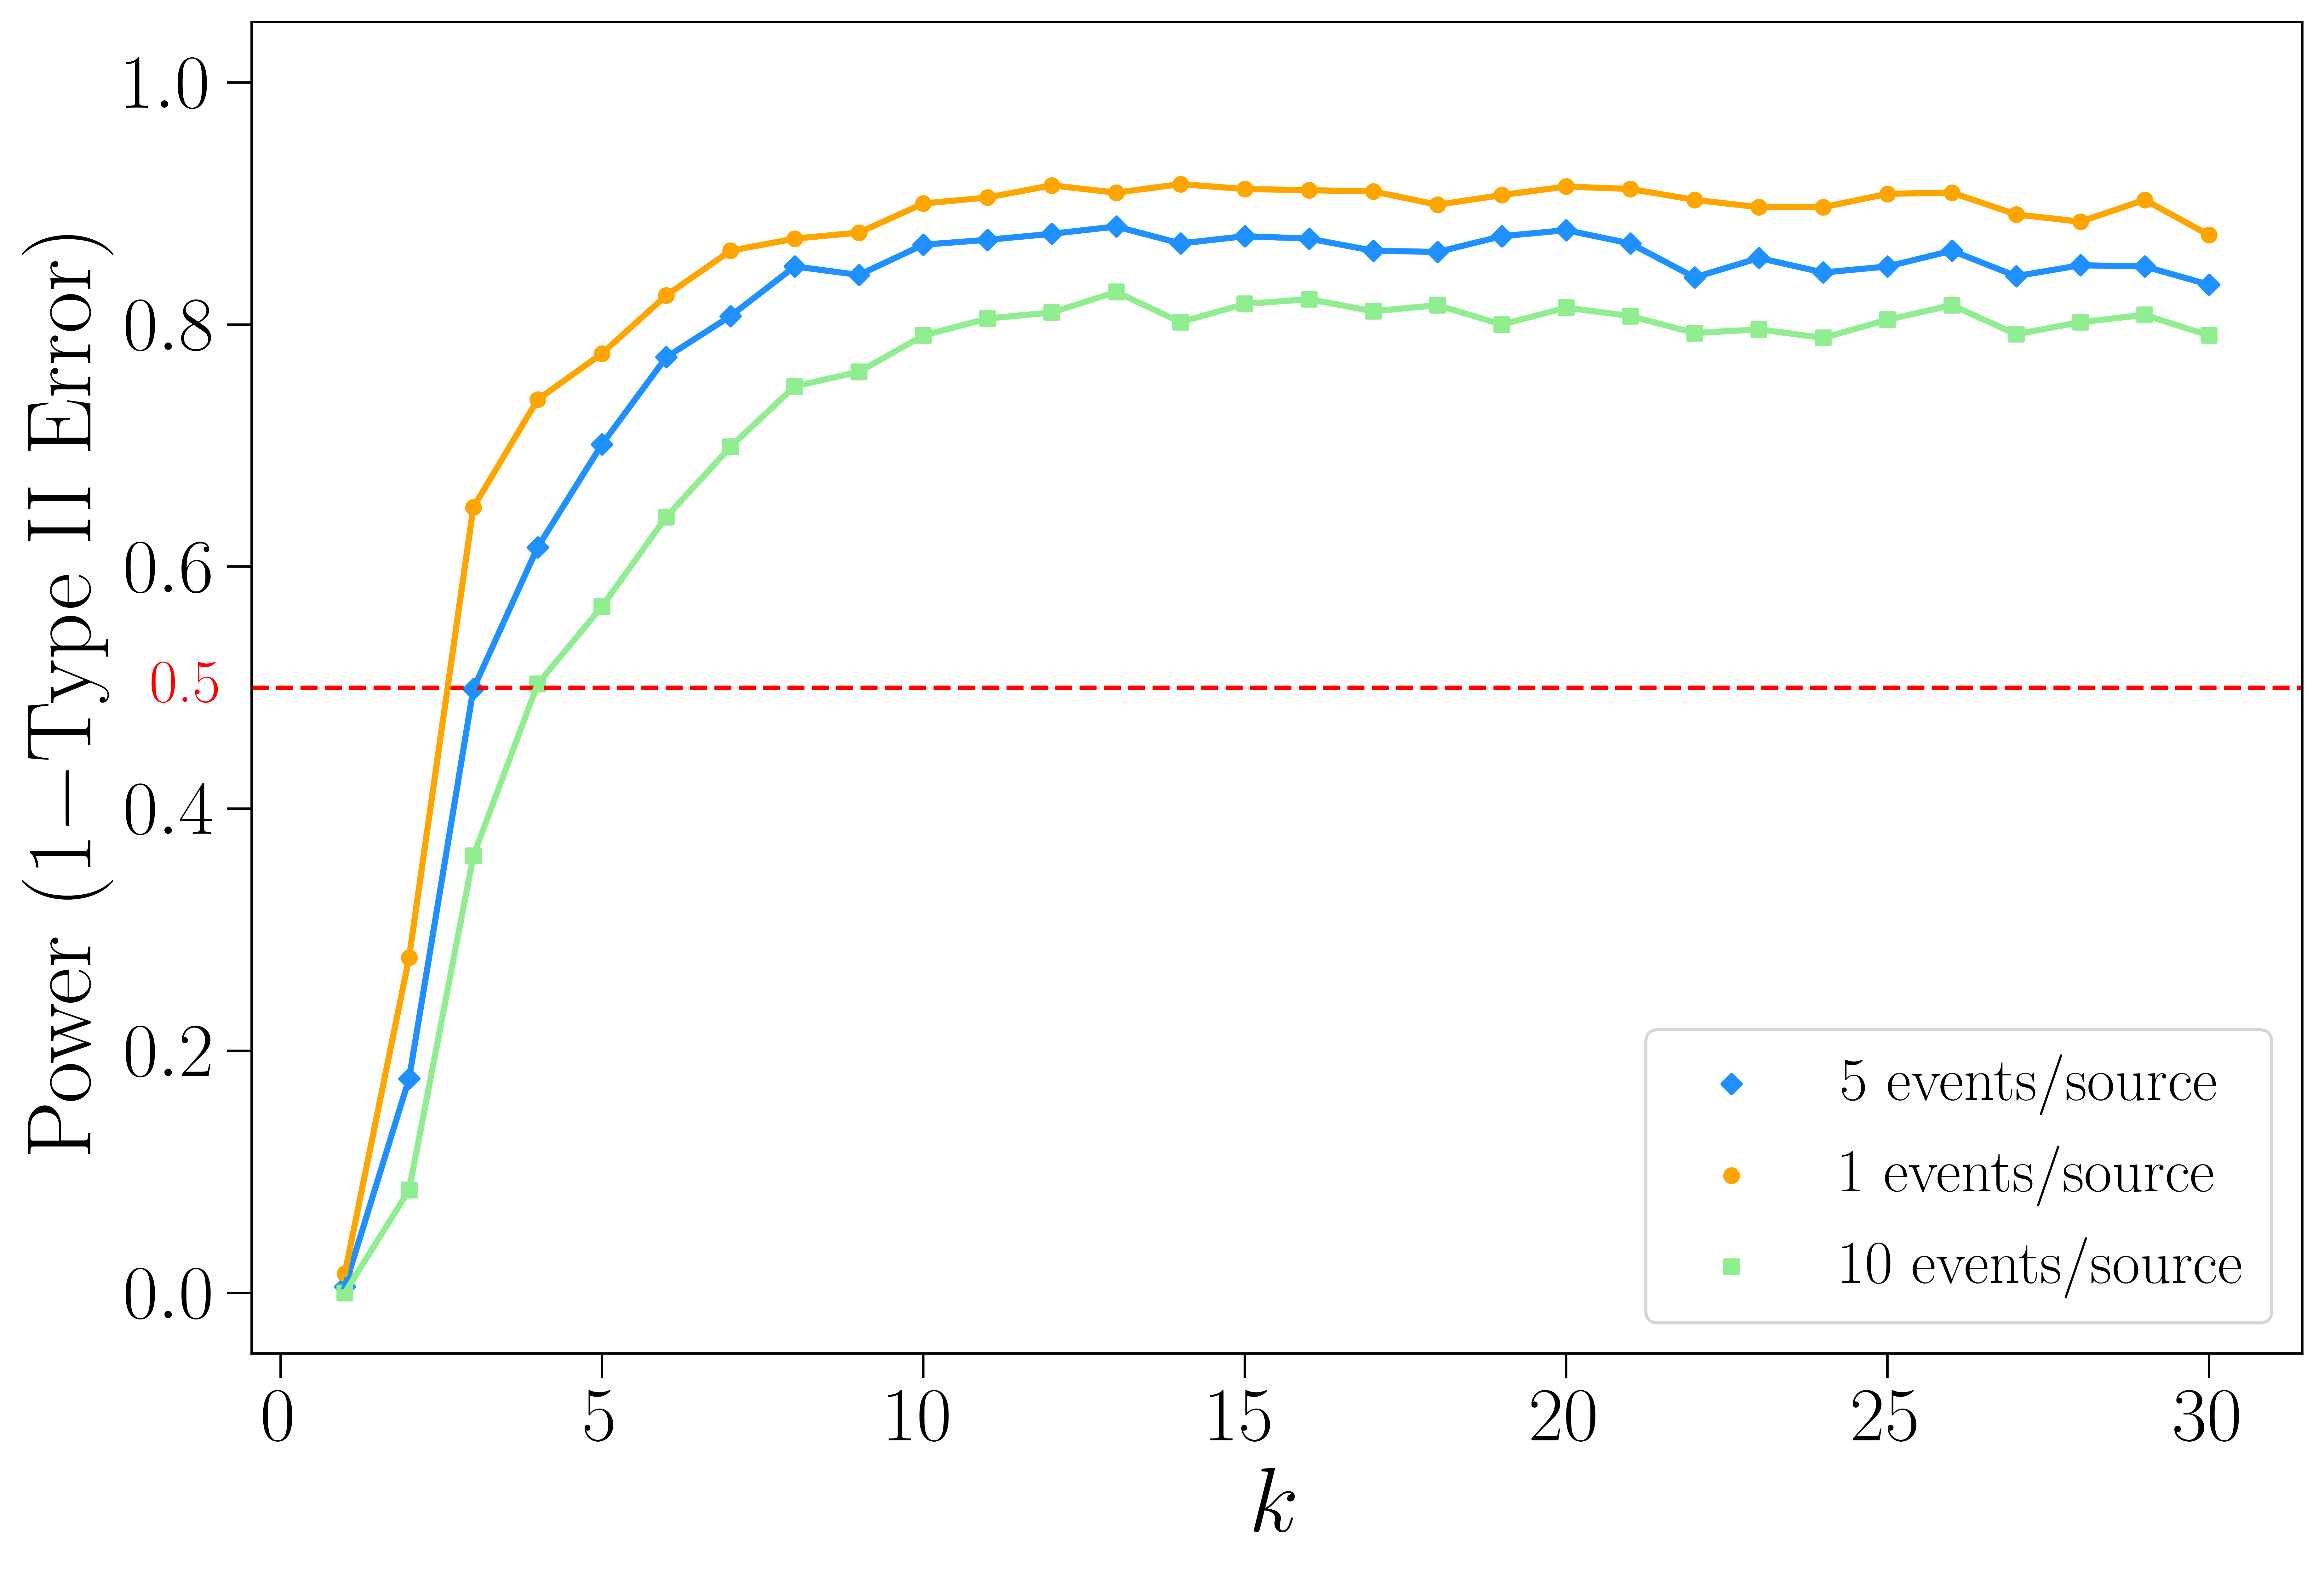

In [10]:
# reproducing Figure 8
plt1 = plt.figure(figsize=(12, 8), dpi = 700)
plt.xlabel('$k$', fontsize=30)
plt.ylabel('Power (1$-$Type II Error)', fontsize=30)
plt.ylim(-0.05, 1.05)

plt.axhline(y=0.5, linewidth=1.5, linestyle="dashed", color = 'r')
plt.text(-0.9, 0.5, '0.5', va='center', ha='right', backgroundcolor='w', color='red', fontsize=20)

plt.xticks(fontsize = 25) 
plt.yticks(fontsize = 25)

plt.tick_params(axis='y', which='major', length=8)
plt.tick_params(axis='x', which='major', length=8)

plt.scatter(x=list(range(1, 31)), y = dp_1, label = "5 events/source", s=20, color = 'dodgerblue', marker="D")
plt.plot(list(range(1, 31)), dp_1, color = 'dodgerblue', linewidth=2)

plt.scatter(x=list(range(1, 31)), y = dp_2, label = "1 events/source", s=20, color = 'orange')
plt.plot(list(range(1, 31)), dp_2, color = 'orange', linewidth=2)

plt.scatter(x=list(range(1, 31)), y = dp_3, label = "10 events/source", s=20, color = 'lightgreen', marker="s")
plt.plot(list(range(1, 31)), dp_3, color = 'lightgreen', linewidth=2)

plt.legend(prop={"family":"Times New Roman", 'size': 20})
plt.show(block=False)

In [11]:
# constraints on discovery potential

In [12]:
k = 7 # set the k at 7 specifically for illustrating discovery potential

TS_null = compute_TS(correlated_cc[0], k) # TS for f_astro = 0
TS = compute_TS(correlated_cc[1], k) # TS for f_astro ~ 0.0186
TS_2 = compute_TS(correlated_cc[2], k) # TS for f_astro ~ 0.0374, median of 5 events/source
TS_3 = compute_TS(correlated_cc[3], k)  # TS for f_astro ~ 0.0374, median of 1 events/source

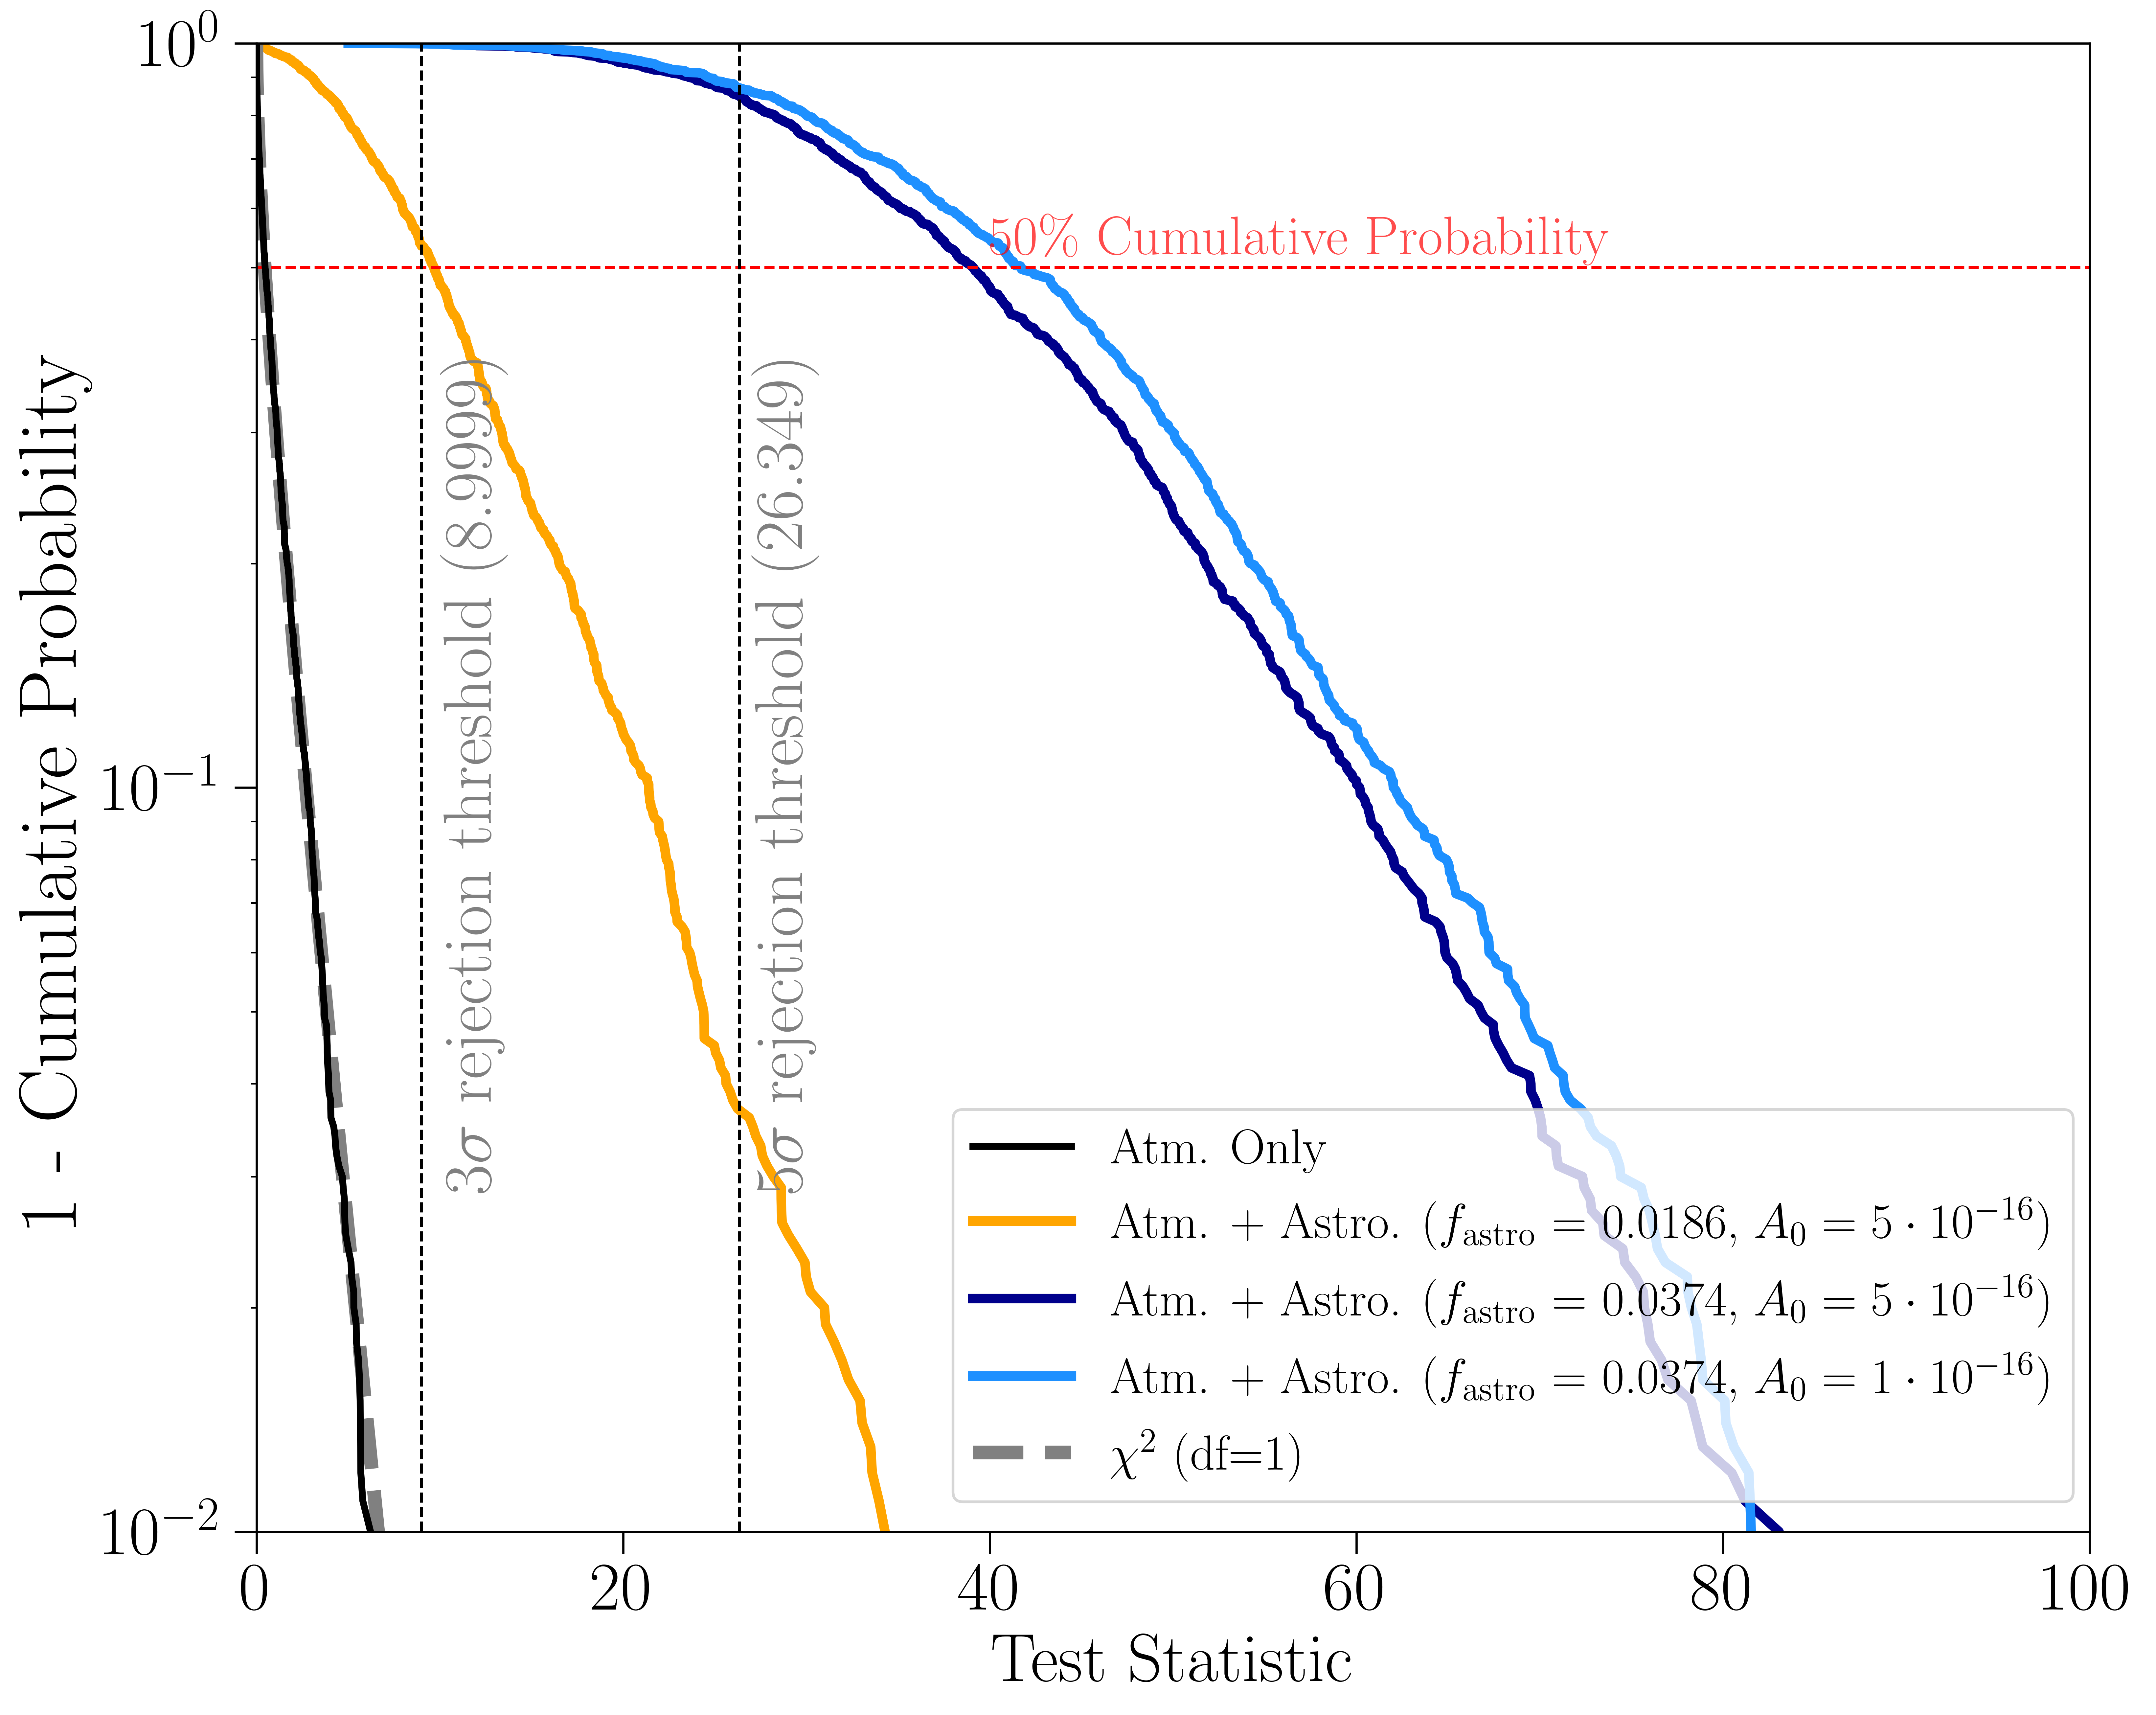

In [13]:
# reproduce Figure 5
plt1 = plt.figure(figsize=(12, 10), dpi=600)
plt.yscale("log")
plt.xlabel('Test Statistic', fontsize=25)
plt.ylabel('1 - Cumulative Probability', fontsize=30)
plt.xlim(0, 100)
plt.ylim(0.01, 1)
plt.xticks(fontsize = 25) 
plt.yticks(fontsize = 25)

plt.tick_params(axis='y', which='major', length=8)
plt.tick_params(axis='x', which='major', length=8)
    
# compute the empirical CDF based on the ranks
x1 = np.sort(TS_null)
y1 = np.arange(len(x1)) * (1/float(len(x1)))
plt.plot(x1, 1 - y1, label = "Atm. Only", color = "black", linewidth=2.5, zorder=3)

x2 = np.sort(TS)
y2 = np.arange(len(x2)) * (1/float(len(x2)))
plt.plot(x2, 1 - y2, label = "Atm. + Astro. ($f_{\mathrm{astro}}$ = 0.0186, $A_0 = 5 \cdot{10}^{-16}$)", 
         color = "orange", linewidth=3.5)

x3 = np.sort(TS_2)
y3 = np.arange(len(x3)) * (1/float(len(x3)))
plt.plot(x3, 1 - y3, label = "Atm. + Astro. ($f_{\mathrm{astro}}$ = 0.0374, $A_0 = 5 \cdot{10}^{-16}$)", 
         color = "darkblue", linewidth=3.5)

x4 = np.sort(TS_3)
y4 = np.arange(len(x4)) * (1/float(len(x4)))
plt.plot(x4, 1 - y4, label = "Atm. + Astro. ($f_{\mathrm{astro}}$ = 0.0374, $A_0 = 1 \cdot{10}^{-16}$)", 
         color = "dodgerblue", linewidth=3.5)

plt.plot(x1, 1-chi2.cdf(x1, df=1), linewidth=5, label = '$\chi^2$ (df=1)', color = "grey", linestyle = "dashed")

plt.axhline(y=0.5, color = "red", linestyle='dashed', linewidth=1)
plt.annotate(f"50\% Cumulative Probability", xy=(40, 0.520), color = "red", fontsize=20, alpha=0.7)

plt.axvline(x=scipy.stats.chi2.ppf(1-2.85e-7, df=1), color = "black", linestyle='dashed', linewidth=1)
plt.annotate(f"$5\sigma$ rejection threshold ({scipy.stats.chi2.ppf(1-2.85e-7, df=1):.5})", xy=(27, 0.030), 
                 rotation=90, color = "grey", fontsize=25)

plt.axvline(x=scipy.stats.chi2.ppf(1-0.0027, df=1), color = "black", linestyle='dashed', linewidth=1)
plt.annotate(f"$3\sigma$ rejection threshold ({scipy.stats.chi2.ppf(1-0.0027, df=1):.5})", xy=(10, 0.030), 
                 rotation=90, color = "grey", fontsize=25)

plt.legend(prop={'size': 18}, loc=(0.38, 0.02))
plt.show(block=False)